not yet done, because of lack of cellreg

In [2]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)


Toggle code

In [3]:
# all modules necessary for this nb
import os
import sys
import pickle

import numpy as np
np.random.seed(0)
import pylab as pl
import scipy.stats as sstats

# setting parameters for default matplotlib plots
%matplotlib inline

In [4]:
pl.style.use('fabiostyle')
# needs to find the library of functions
sys.path.append('../../../code/')  # to be replaced!

import utils as ut
import plots as pt

In [5]:
NOTEBOOK_NAME = 'overlaps_sessions_dhpc_JSB'

In [6]:
from pickleshare import PickleShareDB

autorestore_folder = os.path.join(os.getcwd(), 'autorestore', NOTEBOOK_NAME)
db = PickleShareDB(autorestore_folder)
import sys
from workspace import *
import IPython
ip = IPython.get_ipython()

# this will restore all the saved variables. ignore the errors listed.
# load_workspace(ip, db)

# use `save_worspace(db)` to save variables at the end

In [7]:
from itertools import product
def load_all_animals_vars(varname, animal_list, pilot_list=None, notebook='preprocessing'):
    all_of_them = {}
    for ani in animal_list:
        folder = '../%s/notebooks/autorestore/%s/' % (ani, notebook)
        all_of_them.update({ani: ut.load_variable(varname, folder)})
    return all_of_them

In [8]:
all_animals = 'dhpcg1','dhpcg20','dhpc24' #, 'c4m4', 'c4f3'

#cells_pre_revsht_dn
#cells_preCSmt_up

sessions = 'pre', 'post','pre_rev','post_rev' 
pairs = 'postVSpost_rev', 'preVSpost'

print all_animals
animals = all_animals
prod = product(sessions,
               ['rewardt', 'CSmt','sht'],
               ['','_tr','_us','_cstr','_licks'],
               ['_up', '_dn'],)
for a, b, c, d in prod:
    values = {}
    for ani in animals:
        try:
            values[ani] = ut.load_variable('cells_%s%s%s%s'%(a, b, c, d),
                                           '../%s/notebooks/autorestore/tuning_stability_values_JSB/'%ani)
        except IOError:
            print ani, "cells_", a, b, c, d
    exec('cells_%s%s%s%s = values'%(a, b, c, d))


('dhpcg1', 'dhpcg20', 'dhpc24')
dhpcg1 cells_ pre CSmt _licks _up
dhpcg20 cells_ pre CSmt _licks _up
dhpc24 cells_ pre CSmt _licks _up
dhpcg1 cells_ pre CSmt _licks _dn
dhpcg20 cells_ pre CSmt _licks _dn
dhpc24 cells_ pre CSmt _licks _dn
dhpcg1 cells_ pre sht _licks _up
dhpcg20 cells_ pre sht _licks _up
dhpc24 cells_ pre sht _licks _up
dhpcg1 cells_ pre sht _licks _dn
dhpcg20 cells_ pre sht _licks _dn
dhpc24 cells_ pre sht _licks _dn
dhpcg1 cells_ post CSmt _licks _up
dhpcg20 cells_ post CSmt _licks _up
dhpc24 cells_ post CSmt _licks _up
dhpcg1 cells_ post CSmt _licks _dn
dhpcg20 cells_ post CSmt _licks _dn
dhpc24 cells_ post CSmt _licks _dn
dhpcg1 cells_ post sht _licks _up
dhpcg20 cells_ post sht _licks _up
dhpc24 cells_ post sht _licks _up
dhpcg1 cells_ post sht _licks _dn
dhpcg20 cells_ post sht _licks _dn
dhpc24 cells_ post sht _licks _dn
dhpcg1 cells_ pre_rev CSmt _licks _up
dhpcg20 cells_ pre_rev CSmt _licks _up
dhpc24 cells_ pre_rev CSmt _licks _up
dhpcg1 cells_ pre_rev CSmt _l

In [9]:
for pair in pairs:
    exec("cellregs_%s = {}"%pair)
    for ani in all_animals:
        try:
            eval("cellregs_%s.update({ani:ut.load_variable('cellregs',\
                 '../%s/notebooks/autorestore/decoding_%s/')})" % (pair, ani, pair))
        except IOError:
            print "Empty", pair, ani

Empty postVSpost_rev dhpcg1
Empty postVSpost_rev dhpcg20
Empty postVSpost_rev dhpc24
Empty preVSpost dhpcg1
Empty preVSpost dhpcg20
Empty preVSpost dhpc24


In [87]:
#N = len(cells_postCSmt_us_dn)
n_loops = 50000

def calc_shuffle_overlap(pop1, pop2, n_loops=500):
     return [(np.random.choice([0, 1], size=len(pop1), p=(1-pop1.mean(), pop1.mean()))*
              np.random.choice([0, 1], size=len(pop2), p=(1-pop2.mean(), pop2.mean()))).mean() for r in range(n_loops)]

In [88]:
def sigtest(values, x):
    return [None, 1 - sstats.norm(np.mean(values), np.std(values)).cdf(x)]
def plot_hist(ax, vals, colors=['0.7', 'k'], bins=np.linspace(0, 0.05, 30), ids=[0, 1]):
    # ax.hist(vals2_all[0], bins=10, histtype='step', color='0.7')
    y, x = np.histogram(vals[ids[0]], bins=bins, normed=True)
    ax.step(x[:-1], y*np.diff(x)[0], color=colors[0], lw=1, where='post')
    ax.vlines(vals[ids[1]], 0, 0.4, color=colors[1], lw=1, zorder=19)
    y = np.diff(ax.axis()[-2:])*0.95 + ax.axis()[-2]
    pv = pt.add_significance(ax, vals[ids[0]], vals[ids[1]], vals[ids[1]], vals[ids[1]], y, sig_func=sigtest, ticksize=0)
    pt.nicer_plot(ax)
    return pv

In [89]:
def plot_it(pop1, pop2, untuned, est, labels=['Pre', 'Post', 'Pre+Post', 'Untuned'],
            title="Sucrose", percent=True,
            colors=[(1, 0., 0.2), (1, 0.5, 0.2), (1, 0.8, 0.2), (0.8, 0.8, 
                                                                 0.8)],
            hist_colors=[(1, 0.7, 0.7), 'r'], bins=np.linspace(0, 0.2, 30)):
    fig, axs = pl.subplots(1, 2, figsize=(3, 1))

    ax = axs[0]
    pv = plot_hist(ax, [est, (pop1*pop2).mean()], bins=bins,
            colors=hist_colors)

    ax.set_xlabel('Co-tuned Cells Ratio')
    ax.set_ylabel('PDF')

    ax.set_xlim(0, 0.2)
    ax.set_ylim(0, 0.5)

    ax = axs[1]
    
    t = map(sum, [pop1*~pop2, pop2*~pop1, pop1*pop2, untuned])
    total = np.sum(t)
    _, txts, _ = ax.pie(t, colors=colors, explode=[0.05]*len(t),
                        autopct=(lambda x: "%.1f%%"%(x)) if percent else lambda x: "%.1f"%(x*total/100),
                        labels=labels,
                        textprops={'fontsize':3})
    for tt in txts:
        tt.set_fontsize(5)
    ax.text(1, -1.3, 'n = %d'%total, fontsize=3)

    ax.set_aspect('equal')
    fig.suptitle(title)
    
    return fig, axs, pv

In [90]:
def extract_allcells_pair(pair, animals, stim='rewardt', period='licks'):
    
    sessa, sessb = pair.split('VS')
    
    a_dns = np.concatenate([eval('cells_%s%s%s_dn'%(sessa, stim, period))[ani][eval("cellregs_%s"%pair)[ani][sessa]]
                            for ani in animals])
    a_ups = np.concatenate([eval('cells_%s%s%s_up'%(sessa, stim, period))[ani][eval("cellregs_%s"%pair)[ani][sessa]]
                            for ani in animals])

    b_dns = np.concatenate([eval('cells_%s%s%s_dn'%(sessb, stim, period))[ani][eval("cellregs_%s"%pair)[ani][sessb]]
                            for ani in animals])
    b_ups = np.concatenate([eval('cells_%s%s%s_up'%(sessb, stim, period))[ani][eval("cellregs_%s"%pair)[ani][sessb]]
                            for ani in animals])
    
    pop1 = a_dns+a_ups
    pop2 = b_dns+b_ups
    unt = ~(pop1 + pop2)

    return pop1, pop2, unt

In [91]:
preVSpost_animals =  'c3m1', 'c4m4', 'c3f3', '90', '91', '92', '93', 'c10m6', 'c10m8'
pop1, pop2, unt = extract_allcells_pair('preVSpost', preVSpost_animals, stim='rewardt', period = '_licks')

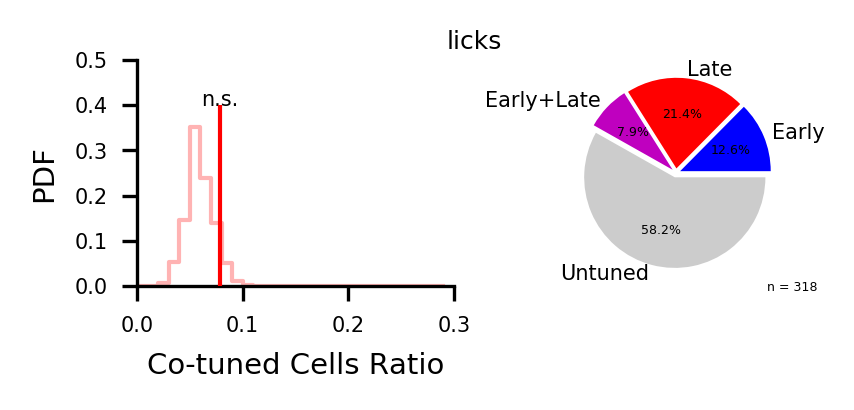

In [92]:
est = calc_shuffle_overlap(pop1, pop2, n_loops=1000)
fig, axs, pv = plot_it(pop1, pop2, unt, est, labels=['Early', 'Late', 'Early+Late', 'Untuned'], title='licks',
                       colors=['b', 'r', 'm', (0.8, 0.8, 0.8)],
                       bins=np.linspace(0, 0.3, 31))
axs[0].set_xlim(0, .3)
# axs[0].set_ylim(0, 0.1)
fig.savefig('../img/%s__licks_preVSpost.pdf'%NOTEBOOK_NAME)
#np.savetxt('../img/%s__CSp_postVSrenew.pvs'%NOTEBOOK_NAME, [pv[-1]], header='One-sided t-test')

In [93]:
postVSrenew_animals = 'c3m1', 'c3m2', 'c4m4', 'c3f3', '90', '92', '93', 'c10m6', 'c10m8'
pop1, pop2, unt = extract_allcells_pair('postVSpost_rev', postVSrenew_animals, stim='rewardt', period ='_licks' )

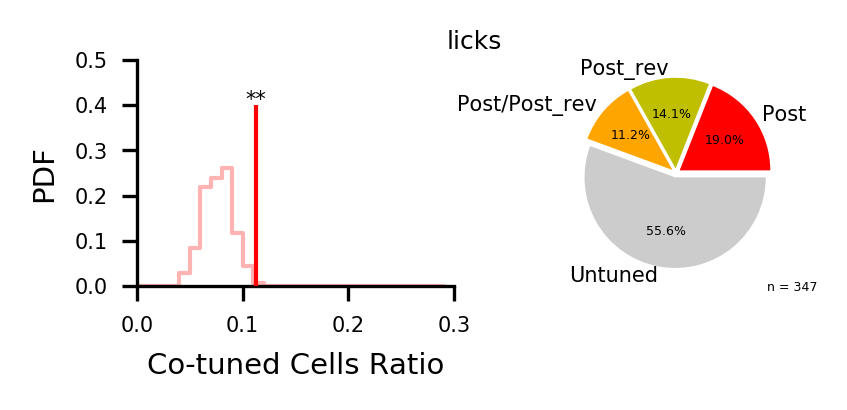

In [94]:
est = calc_shuffle_overlap(pop1, pop2, n_loops=1000)
fig, axs, pv = plot_it(pop1, pop2, unt, est, labels=['Post', 'Post_rev', 'Post/Post_rev', 'Untuned'], title='licks',
                       colors=['r', 'y', 'orange', (0.8, 0.8, 0.8)], bins=np.linspace(0, 0.3, 31))
axs[0].set_xlim(0, .3)
# axs[0].set_ylim(0, 0.1)
fig.savefig('../img/%s__licks_postVSpost_rev.pdf'%NOTEBOOK_NAME)
#np.savetxt('../img/%s__CSp_postVSrenew.pvs'%NOTEBOOK_NAME, [pv[-1]], header='One-sided t-test')

In [95]:
postVSrenew_animals = 'c3m1', 'c3m2', 'c4m4', 'c3f3', '90', '92', '93', 'c10m6', 'c10m8'
pop1, pop2, unt = extract_allcells_pair('postVSpost_rev', postVSrenew_animals, stim='rewardt', period ='' )

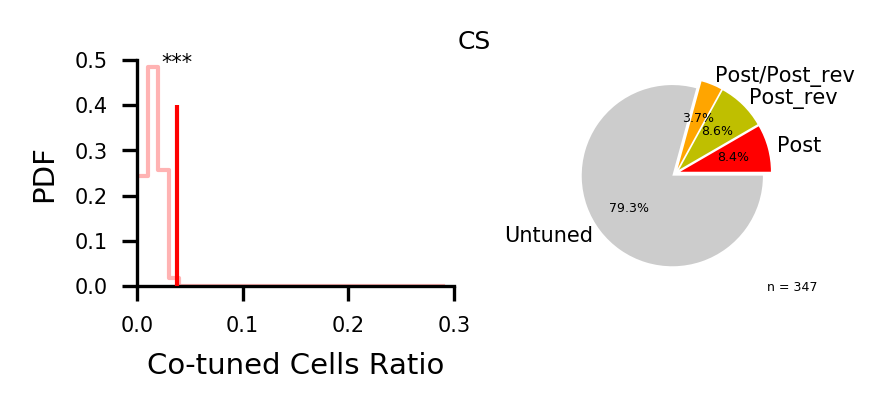

In [96]:
est = calc_shuffle_overlap(pop1, pop2, n_loops=1000)
fig, axs, pv = plot_it(pop1, pop2, unt, est, labels=['Post', 'Post_rev', 'Post/Post_rev', 'Untuned'], title='CS',
                       colors=['r', 'y', 'orange', (0.8, 0.8, 0.8)], bins=np.linspace(0, 0.3, 31))
axs[0].set_xlim(0, .3)
# axs[0].set_ylim(0, 0.1)
fig.savefig('../img/%s__cs_postVSpost_rev.pdf'%NOTEBOOK_NAME)
#np.savetxt('../img/%s__CSp_postVSrenew.pvs'%NOTEBOOK_NAME, [pv[-1]], header='One-sided t-test')

In [97]:
postVSrenew_animals = 'c3m1', 'c3m2', 'c4m4', 'c3f3', '90', '92', '93', 'c10m6', 'c10m8'
pop1, pop2, unt = extract_allcells_pair('postVSpost_rev', postVSrenew_animals, stim='rewardt', period ='_tr' )

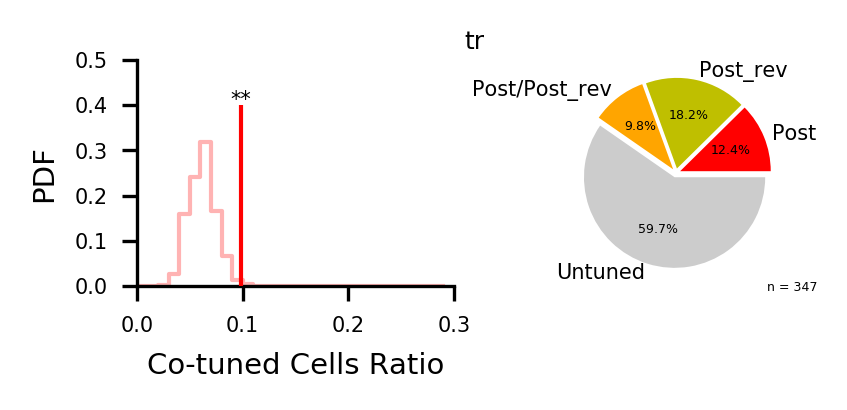

In [98]:
est = calc_shuffle_overlap(pop1, pop2, n_loops=1000)
fig, axs, pv = plot_it(pop1, pop2, unt, est, labels=['Post', 'Post_rev', 'Post/Post_rev', 'Untuned'], title='tr',
                       colors=['r', 'y', 'orange', (0.8, 0.8, 0.8)], bins=np.linspace(0, 0.3, 31))
axs[0].set_xlim(0, .3)
# axs[0].set_ylim(0, 0.1)
fig.savefig('../img/%s__tr_postVSpost_rev.pdf'%NOTEBOOK_NAME)
#np.savetxt('../img/%s__CSp_postVSrenew.pvs'%NOTEBOOK_NAME, [pv[-1]], header='One-sided t-test')

In [99]:
save_workspace(db)

Could not store variable 'IPython'. Skipping...
Could not store variable 'sstats'. Skipping...
Could not store variable 'pickle'. Skipping...
Could not store variable 'di'. Skipping...
Could not store variable 'pt'. Skipping...
Could not store variable 'pl'. Skipping...
Could not store variable 'ip'. Skipping...
Could not store variable 'sys'. Skipping...
Could not store variable 'os'. Skipping...
Could not store variable 'ut'. Skipping...
Could not store variable 'np'. Skipping...
